# ANGOLO DI BRAGG

$n\lambda = 2d \sin\theta$

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import jax.numpy as jnp
from jax import grad
import os
import sys
from scipy.optimize import curve_fit

dir_path = os.path.abspath('')
sys.path.append(dir_path + '/../')

from giopy import Interpolazione, final_val

dir_path = os.path.abspath('')
FILE2 = dir_path + '/data/' + 'bragg2.csv'
fr2 = pd.read_csv(FILE2)

FILE1 = dir_path + '/data/' + 'bragg1.csv'
fr1 = pd.read_csv(FILE1)

In [3]:
α2 = np.array(fr2['teta'])
sigmaα2 = 1 * np.ones(len(α2))

V2 = np.array(fr2['V']) * 0.001
sigmaV2 = np.array(fr2['sigmaV']) * 0.001

α1 = np.array(fr1['teta (angolo incidente)'])
sigmaα1 = 1 * np.ones(len(α1))

V1 = np.array(fr1['V (mV)']) * 0.001
sigmaV1 = np.array(fr1['sigmaV']) * 0.001

d = 0.03 # distanza centri reticolo cristallino
sigmad = 0.001 # mm


fr = pd.read_csv(dir_path + '/output.csv')
λ = np.float64(fr['λ'])
sigmaλ = np.float64(fr['σλ'])

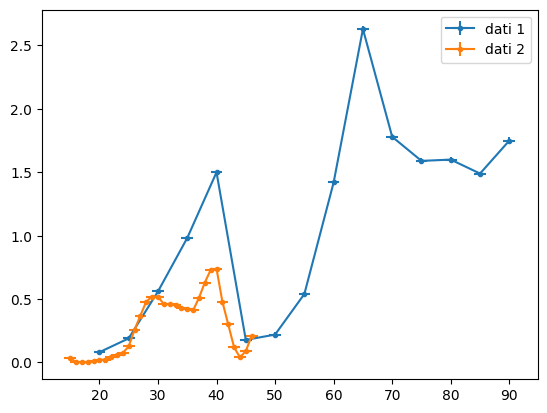

In [4]:
plt.errorbar(α1, V1, yerr=sigmaV1,xerr=sigmaα1, fmt='.-', label='dati 1')
plt.errorbar(α2, V2, yerr=sigmaV2,xerr=sigmaα2, fmt='.-', label='dati 2')
plt.legend()
plt.show()

#### ANGOLI -> DISTANZA RETICOLO:

$(m-n)\lambda = 2d(\sin\theta_2-\sin\theta_1) \Rightarrow d = \frac{\lambda}{2(\sin\theta_2 - \sin\theta_1)}$

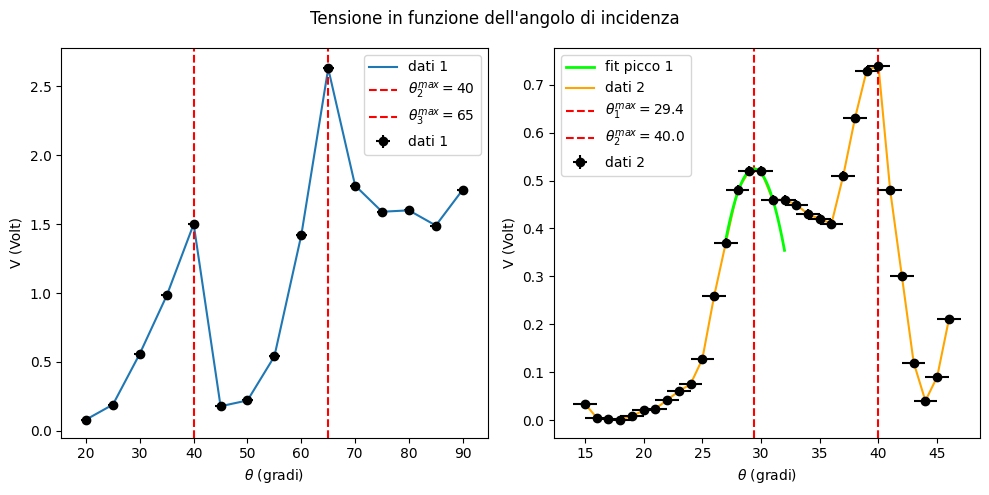

θ1:  29.41 ± 0.66 deg


In [16]:

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 5))

# massimi dati 2: (fit con parabole gli intorni dei massimi)

def parabola(x, a, b, θ):
    return a * (x - θ)**2 + b

# def parabolic_max(x,a,b,θ,p):
#     return a * (x - θ)**2 + b * (x - θ) + p

a1,b1 = 12,17
a2,b2 = 23,27
fit_picco1 = Interpolazione(α2[a1:b1], V2[a1:b1], sigmaV2[a1:b1],sigmaα2[a1:b1], parabola, [-0.1, 0.1, α2[16]],names=['a','b','θ'], iteration=2)
# fit_picco2 = Interpolazione(α2[a2:b2], V2[a2:b2], sigmaV2[a2:b2],sigmaα2[a2:b2], parabolic_max, [-0.1, 0.1, α2[24],2],names=['a','b','θ','p'], iteration=2)
# NOTA: non c'è verso di fittare il secondo massimo con andamenti parabolici

# plt.errorbar(α1,V1, yerr=sigmaV1, xerr=sigmaα1, fmt='o',color='red',ecolor='red',capsize=0, label='fit picco 1')

ax2.errorbar(α2,V2, yerr=sigmaV2, xerr=sigmaα2, fmt='ok', label='dati 2',zorder=10)
x = np.linspace(α2[a1],α2[b1],100)
y = parabola(x,*list(fit_picco1.values.values()))
ax2.plot(x,y,label='fit picco 1',zorder=5,linewidth=2,color='lime')
ax2.plot(α2,V2, '-', label='dati 2',color='orange')
ax2.axvline(x=fit_picco1.values['θ'], color='r', linestyle='--', label='$\\theta_1^{max} = '+ str(np.round(fit_picco1.values['θ'],1)) +'$')
ax2.axvline(x=40, color='r', linestyle='--', label='$\\theta_2^{max} = ' + str(40.0) +'$')
ax2.legend()
ax2.set_xlabel('$\\theta$ (gradi)')
ax2.set_ylabel('V (Volt)')

ax1.errorbar(α1,V1, yerr=sigmaV1, xerr=sigmaα1, fmt='ok', label='dati 1')
ax1.plot(α1,V1, '-', label='dati 1')
ax1.axvline(x=α1[4], color='r', linestyle='--', label='$\\theta_2^{max} = '+ str(np.round(α1[4],1)) +'$')
ax1.axvline(x=α1[9], color='r', linestyle='--', label='$\\theta_3^{max} = ' + str(np.round(α1[9],1)) +'$')
ax1.legend()
ax1.set_xlabel('$\\theta$ (gradi)')
ax1.set_ylabel('V (Volt)')

fig.suptitle("Tensione in funzione dell'angolo di incidenza")
plt.tight_layout()
plt.show()


print('θ1: ',final_val(fit_picco1.values['θ'],fit_picco1.errors['θ'],udm='deg'))

In [6]:
θ1,θ2,θ3 = np.array([29.4,40,65]) * np.pi/180
sigmaθ = 1 * np.pi/180

def passo_critallino(λ,θ1,θ2):
    return λ/(2*(jnp.sin(θ2) - jnp.sin(θ1)))

d12 = passo_critallino(λ,θ1,θ2)
λ_grad,θ1_grad,θ2_grad = grad(passo_critallino,(0,1,2))(λ,θ1,θ2) # compie le derivate parziali rispetto ai parametri
sigmad12 = np.sqrt((λ_grad*sigmaλ)**2 + (θ1_grad*sigmaθ)**2 + (θ2_grad*sigmaθ)**2 + 
                   2*λ_grad*θ1_grad*sigmaθ*sigmaλ + 2*θ2_grad*λ_grad*sigmaλ*sigmaθ + 2*θ1_grad*θ2_grad*sigmaθ*sigmaθ) # propagazione dell'errore
print('d12: ',final_val(d12,sigmad12,2,-2,'m'))


d23 = passo_critallino(λ,θ2,θ3)
λ_grad,θ2_grad,θ3_grad = grad(passo_critallino,(0,1,2))(λ,θ2,θ3)
sigmad23 = np.sqrt((λ_grad*sigmaλ)**2 + (θ2_grad*sigmaθ)**2 + (θ3_grad*sigmaθ)**2 + 
                   2*λ_grad*θ2_grad*sigmaθ*sigmaλ + 2*θ3_grad*λ_grad*sigmaλ*sigmaθ + 2*θ2_grad*θ3_grad*sigmaθ*sigmaθ)
print('d23: ',final_val(d23,sigmad23,2,-2,'m'))

d13 = passo_critallino(λ,θ1,θ3)
λ_grad,θ1_grad,θ3_grad = grad(passo_critallino,(0,1,2))(λ,θ1,θ3)
sigmad13 = np.sqrt((λ_grad*sigmaλ)**2 + (θ1_grad*sigmaθ)**2 + (θ3_grad*sigmaθ)**2 + 
                   2*λ_grad*θ1_grad*sigmaθ*sigmaλ + 2*θ3_grad*λ_grad*sigmaλ*sigmaθ + 2*θ1_grad*θ3_grad*sigmaθ*sigmaθ)
print('d13: ',final_val(d13,sigmad13,2,-2,'m'))

d12:  (9.28 ± 0.46)e-2 m
d23:  (5.3500000000000005 ± 0.32)e-2 m
d13:  (3.39 ± 0.19)e-2 m


il passo del reticolo noto è di 4 cm se si considerano i centri delle sfere, 3 se si considerano gli estremi.
il passo d13 è il più vicino al valore misurato in laboratorio.
d12 è multiplo di 4, ma non son stati rilevati ulteriori picchi

## STIMA ANGOLI ATTESI:

$\theta = \arcsin(\frac{n\lambda}{2d})$

In [11]:
d = 0.04 # distanza centri reticolo cristallino
sigmad = 0.001 # 1mm

FILE = dir_path + '/output.csv'
fr = pd.read_csv(FILE)

λ = np.float64(fr['λ'])
sigmaλ = np.float64(fr['σλ'])

def angolo_bragg(d,λ,n):
    return jnp.arcsin(n*λ/(2*d))

θ1 = angolo_bragg(d,λ,1) *180/np.pi
λ_grad,d_grad = grad(angolo_bragg,(1,0))(d,λ,1)
sigmaθ1 = np.sqrt((λ_grad*sigmaλ)**2 + (d_grad*sigmad)**2 + 2*λ_grad*d_grad*sigmaλ*sigmad) *180/np.pi

θ2 = angolo_bragg(d,λ,2) *180/np.pi
λ_grad,d_grad = grad(angolo_bragg,(1,0))(d,λ,2)
sigmaθ2 = np.sqrt((λ_grad*sigmaλ)**2 + (d_grad*sigmad)**2 + 2*λ_grad*d_grad*sigmaλ*sigmad) *180/np.pi

print('d: 0.04m')
print('θ1: ',final_val(θ1,sigmaθ1,2,udm='deg'))
print('θ2: ',final_val(θ2,sigmaθ2,2,udm='deg'))

print('...................................')

d = 0.03 # distanza centri reticolo cristallino
sigmad = 0.001 # 1mm

θ1 = angolo_bragg(d,λ,1) *180/np.pi
λ_grad,d_grad = grad(angolo_bragg,(1,0))(d,λ,1)
sigmaθ1 = np.sqrt((λ_grad*sigmaλ)**2 + (d_grad*sigmad)**2 + 2*λ_grad*d_grad*sigmaλ*sigmad) *180/np.pi

θ2 = angolo_bragg(d,λ,2) *180/np.pi
λ_grad,d_grad = grad(angolo_bragg,(1,0))(d,λ,2)
sigmaθ2 = np.sqrt((λ_grad*sigmaλ)**2 + (d_grad*sigmad)**2 + 2*λ_grad*d_grad*sigmaλ*sigmad) *180/np.pi

print('d: 0.03m')
print('θ1: ',final_val(θ1,sigmaθ1,2,udm='deg'))
print('θ2: ',final_val(θ2,sigmaθ2,2,udm='deg'))


d: 0.04m
θ1:  20.63 ± 0.26 deg
θ2:  44.800000000000004 ± 0.68 deg
...................................
d: 0.03m
θ1:  28.02 ± 0.11 deg
θ2:  69.98 ± 0.58 deg


se il passo è considerando i centri delle sfere ci siamo persi il $\theta_1$, se il passo è ottenuto considerando gli estremi delle sfere bisogna formulare una qualche ipotesi riguardo alla comparsa del picco $\theta_2$

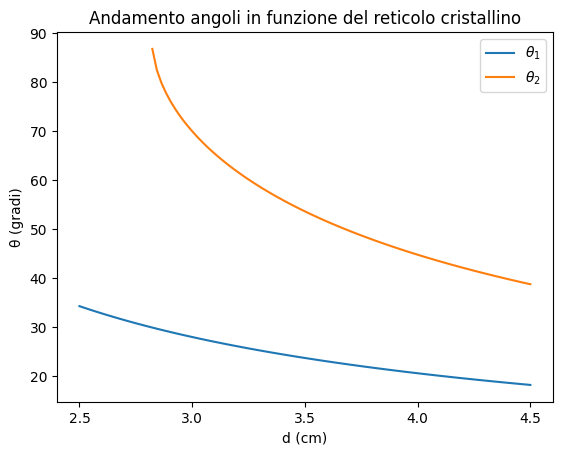

In [14]:
## Andamento angoli in funzione del reticolo cristallino:

d = np.linspace(0.025,0.045,100)
θ1 = angolo_bragg(d,λ,1) *180/np.pi
θ2 = angolo_bragg(d,λ,2) *180/np.pi


plt.errorbar()

plt.plot(d,θ1,label='$\\theta_1$')
plt.plot(d,θ2,label='$\\theta_2$')
plt.legend()
plt.xticks([0.025,0.03,0.035,0.04,0.045],['2.5','3.0','3.5','4.0','4.5'])
plt.xlabel('d (cm)')
plt.ylabel('θ (gradi)')
plt.title('Andamento angoli in funzione del reticolo cristallino')
plt.show()